In [41]:
from skimage.util import img_as_ubyte
from sklearn import svm
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import cv2
import os
from skimage import io
from skimage.filters import threshold_otsu
from skimage.segmentation import  flood_fill
from skimage.feature import peak_local_max
from skimage.feature import hog
from skimage.filters import sobel
from skimage.morphology import skeletonize
from skimage.measure import find_contours
from skimage.draw import rectangle
import math
from matplotlib.pyplot import bar
import matplotlib.pyplot as plt
from skimage.transform import hough_line, hough_line_peaks, rotate
import numpy as np
import time
import glob
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree




In [2]:
# Show the figures / plots inside the notebook
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 


In [4]:
def auto_crop(binary_image: np.ndarray) -> np.ndarray:
    all_points = cv2.findNonZero(binary_image)
    x, y, w, h = cv2.boundingRect(all_points)
    height, width = binary_image.shape
    border = 0
    left = max(0, x - border)
    right = min(width, x + w + border)
    top = max(0, y - border)
    bottom = min(height, y + h + border)
    return binary_image[top:bottom, left:right], top, bottom


In [5]:
######## return hog features from input image #########
def extract_hog_features(img):
    img = cv2.resize(img, (110, 200))
    fd = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)
    return fd

In [6]:
######## binarize image ##########
def local_binarize(img, block_size = 35, offset_val = 10):
    img=img_as_ubyte(img)
    b_img= img < threshold_otsu(img)
    return b_img    

In [7]:
####### function that returns the row of the text basline #######
def baseline(img):
    horizontal_projection = np.sum(img, axis=1)
    return np.argmax(horizontal_projection)

In [8]:
###### function that takes the folder of the dataset then returns array of images and their labels ########
def load_images_from_folder(folders):
    images = []
    y=[]
    i = 1
    for folder in folders:   
        for filename in os.listdir(folder):
            img = io.imread(os.path.join(folder,filename), 1)
            if img is not None:
                b_img=local_binarize(img)
                baseline_i=baseline(b_img)
                if np.sum(b_img[baseline_i])>=(b_img.shape[1]-2):
                    b_img= 1-b_img
                images.append(b_img)
                
                y.append(i)
        i+=1
    return images, y

In [9]:
######### Horizontal profile projection ###########
def HPP(img):
    horizontal_projection = np.sum(img, axis=1)
    return np.histogram(horizontal_projection, bins=10)[0]


In [10]:
def count_contour(img,minArea):
    find_contour_img=find_contours(img, 0.8)
    i=0
    vertical_lines_height = []
    max_height = 0.0001
    variance=0
    for box in find_contour_img:  
        Xmin=min(box[:,1])
        Xmax=max(box[:,1])
        Ymin=min(box[:,0])
        Ymax=max(box[:,0])
        if (Ymax-Ymin)*(Xmax-Xmin)>minArea:
            vertical_lines_height.append(Ymax-Ymin)
            i+=1
    if vertical_lines_height != []:
        max_height=max(vertical_lines_height)
        variance=np.var(vertical_lines_height)
    return i, max_height, variance

In [11]:
def count_contours_full(img,minArea):
    img=img.astype('uint8')
    find_contour_img=find_contours(img,0.8)
    final= np.zeros(img.shape)
    i=0
    a=[]
    for box in find_contour_img:  
        Xmin=min(box[:,1])
        Xmax=max(box[:,1])
        Ymin=min(box[:,0])
        Ymax=max(box[:,0])
        if (Ymax-Ymin)*(Xmax-Xmin)>minArea:
            rr, cc = rectangle(start = (math.ceil(0),math.ceil(Xmin)), end = (math.ceil(img.shape[0]),math.ceil(Xmax)), shape=img.shape)
            final[rr,cc]=1
            i+=1
            a.append([[Ymax,Xmax],[Ymax,Xmin],[Ymin,Xmin],[Ymin,Xmax]])

    return i, a

In [12]:
def black_white_ratio(b_img):
    white=np.sum(b_img==1)
    black=np.sum(b_img==0)
    temp=[]
    if (black==0):
        temp.append(0)
        return temp
    temp.append(white/black )
    return  temp  


In [13]:
def black_white_ratio_up(b_img):
    baseline_i=baseline(b_img)
    white=np.sum(b_img[0:baseline_i,:]==1)
    black=np.sum(b_img[0:baseline_i,:]==0)
    temp=[]
    if (black==0):
        temp.append(0)
        return temp
    temp.append(white/black )
    return  temp

In [14]:

def black_white_ratio_down(b_img):
    baseline_i=baseline(b_img)
    white=np.sum(b_img[baseline_i:,:]==1)
    black=np.sum(b_img[baseline_i:,:]==0)
    temp=[]
    if (black==0):
        temp.append(0)
        return temp
    temp.append(white/black )
    return  temp 

In [15]:
def density_up(b_img,min_area):
    baseline_i=baseline(b_img)
    temp=[]
    if baseline_i<=2:
        temp.append(0)
        return temp 
    y,_=count_contours_full(b_img,min_area)
    x,_=count_contours_full(b_img[0:baseline_i,:],min_area)
    
    temp.append(x/y)
    return temp

In [16]:
def density_down(b_img,min_area):
    baseline_i=baseline(b_img)
    temp=[]
    if baseline_i>=b_img.shape[0]-5:
        show_images([b_img],['nn'])
        temp.append(0)
        return temp 
    y,_=count_contours_full(b_img,min_area)
    x,_=count_contours_full(b_img[baseline_i:,:],min_area)
    
    temp.append(x/y)
    return temp
    

In [17]:
def min_rect(img):
    rotations=[]
    contours = cv2.findContours(img.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] 
    for j,contour in enumerate(contours):
            box = cv2.minAreaRect(contour)
            rotations.append(box[2])   
    avg_angle=sum(rotations)/len(rotations) 
    return avg_angle

In [18]:
######### takes binary image and returns skeleton, edge
def processing_images(binary_img):
    bw_img=binary_img
    sobel_img = sobel(bw_img)
    skeletonized_img=skeletonize(bw_img)
    return sobel_img, skeletonized_img

In [19]:
####### function that returns num of horizontal and vertical lines
def HVSL(bw_image):
    # hough line to detect lines in the photo
    tested_angles = np.linspace(-np.pi, np.pi, 360)
    h, theta, d = hough_line(bw_image, theta=tested_angles)
    origin = np.array((0, bw_image.shape[1]))
    # hough peaks to get those lines
    angles=[]
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        angles.append(angle)
    angles = [angle * 180 / np.pi for angle in angles]
    return angles.count(90.0), angles.count(180.0), len(angles)




In [20]:

def HVSL_features(edge):
    vertical_lines, horizontal_lines, lines = HVSL(edge)
    if(vertical_lines+horizontal_lines) == 0:
        horizontal_lines=.0001
    if(lines==0):
        lines=.0001
    freq_appearance_ratio = np.count_nonzero(edge)/lines
    ratio_pixels_HVL = np.count_nonzero(edge)/freq_appearance_ratio
    return freq_appearance_ratio, ratio_pixels_HVL
    

In [21]:
def text_height_feature(skeleton):
    skeleton = img_as_ubyte(skeleton)
    kernel_vertical_line=np.ones((3,1))
    line = cv2.morphologyEx(skeleton, cv2.MORPH_OPEN, kernel_vertical_line)
    line=line/255
    num_of_verticle_lines, max_vertical_line_height, variance = count_contour(line,3*1)
    _, start_height, end_height  = auto_crop(skeleton)
    text_height = abs(start_height-end_height)
    return text_height, num_of_verticle_lines, max_vertical_line_height, text_height/max_vertical_line_height , variance


In [22]:
def text_thickness(edge_img, skeleton_img):
    row = min (skeleton_img.shape[0], edge_img.shape[0])
    col = min (skeleton_img.shape[1], edge_img.shape[1])
    dist = []
    left = 0
    right = 0
    l = False
    r = False
    for i in range (row-1):
        for j in range (col-1):
            l = False
            r = False
            if skeleton_img[i][j] == 1:
                max1 = max(j-10,0)
                min2 = min(j+10,col)
                for k in range(j,max1,-1):
                    if edge_img[i][k] > 0:
                        left = k
                        l = True
                        break
                for g in range(j,min2):
                    if edge_img[i][g] > 0:
                        right = g
                        r = True
                        break
                if l == False:
                    left = j
                if r == False:
                    right = j
                dist.append(abs(right-left))
    h = np.histogram(dist)
    return h[0]


In [103]:
############### function that extracts all features from dataset ###################
def process_LVL_HVSL(x):
    featuresLVL =[]
    featuresHVSL=[]
    HPP_features=[]
    featuresToE=[]
    featuresToS=[]
    featuresThickness=[]
    HOG=[]
    black_white=[]
    black_white_up=[]
    black_white_down=[]
    d_up=[]
    d_down=[]
    m_rect=[]
    for _, path in enumerate(x):
        img = io.imread(path, 1)
        HOG.append(extract_hog_features(img))
        bw_img=local_binarize(img)
        # show_images([bw_img],['b'])
        edge, skeleton = processing_images(bw_img)
        featuresLVL.append(text_height_feature(skeleton))
        featuresHVSL.append(HVSL_features(edge))
        baseline_i=baseline(bw_img)
        if np.sum(bw_img[baseline_i])>=(bw_img.shape[1]-5):
            bw_img= 1-bw_img
        HPP_features.append(HPP(bw_img))
        featuresThickness.append(text_thickness(edge, skeleton))
        skeleton = img_as_ubyte(skeleton)
        edge = img_as_ubyte(edge)
        featuresToS.append(extract_hog_features(skeleton))
        featuresToE.append(extract_hog_features(edge))
        black_white.append(black_white_ratio(bw_img))
        black_white_up.append(black_white_ratio_up(bw_img))
        black_white_down.append(black_white_ratio_down(bw_img))
        d_up.append(density_up(bw_img,3))
        d_down.append(density_down(bw_img,3))
        m_rect.append([min_rect(bw_img)])
    return featuresLVL,featuresHVSL, HPP_features, featuresToS, featuresToE,featuresThickness, HOG,black_white,black_white_up,black_white_down,d_up,d_down,m_rect

In [104]:

def main(x):
    XLVL, XHVSL, HPP_features, featuresToS, featuresToE, featuresThickness, HOG,bw,bw_up,bw_down,d_up,d_down,m_rect = process_LVL_HVSL(x)
    return XLVL, XHVSL, HPP_features, featuresToS, featuresToE, featuresThickness, HOG,bw,bw_up,bw_down,d_up,d_down,m_rect 

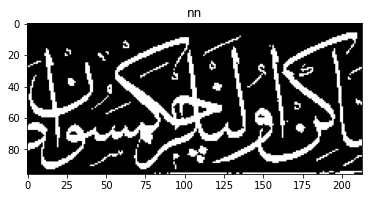

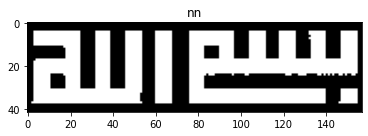

In [106]:

x = glob.glob("D:\\4th year\\1st semester\\pattern recognition\\project\\ACdata_base\\1\\*")

x.extend(glob.glob("D:\\4th year\\1st semester\\pattern recognition\\project\\ACdata_base\\2\\*"))
x.extend(glob.glob("D:\\4th year\\1st semester\\pattern recognition\\project\\ACdata_base\\3\\*"))
x.extend(glob.glob("D:\\4th year\\1st semester\\pattern recognition\\project\\ACdata_base\\4\\*"))
x.extend(glob.glob("D:\\4th year\\1st semester\\pattern recognition\\project\\ACdata_base\\5\\*"))
x.extend(glob.glob("D:\\4th year\\1st semester\\pattern recognition\\project\\ACdata_base\\6\\*"))
x.extend(glob.glob("D:\\4th year\\1st semester\\pattern recognition\\project\\ACdata_base\\7\\*"))
x.extend(glob.glob("D:\\4th year\\1st semester\\pattern recognition\\project\\ACdata_base\\8\\*"))
x.extend(glob.glob("D:\\4th year\\1st semester\\pattern recognition\\project\\ACdata_base\\9\\*"))
_, y = load_images_from_folder(["D:\\4th year\\1st semester\\pattern recognition\\project\\ACdata_base\\1","D:\\4th year\\1st semester\\pattern recognition\\project\\ACdata_base\\2","D:\\4th year\\1st semester\\pattern recognition\\project\\ACdata_base\\3","D:\\4th year\\1st semester\\pattern recognition\\project\\ACdata_base\\4","D:\\4th year\\1st semester\\pattern recognition\\project\\ACdata_base\\5","D:\\4th year\\1st semester\\pattern recognition\\project\\ACdata_base\\6","D:\\4th year\\1st semester\\pattern recognition\\project\\ACdata_base\\7","D:\\4th year\\1st semester\\pattern recognition\\project\\ACdata_base\\8","D:\\4th year\\1st semester\\pattern recognition\\project\\ACdata_base\\9"])


XLVL, XHVSL, HPP_features, featuresToS, featuresToE, featuresThickness, HOG,bw,bw_up,bw_down,d_up,d_down,m_rect  = main(x)


In [142]:

X_train, X_test, y_train, y_test = model_selection.train_test_split(XLVL, y, test_size=0.2, random_state=1)
XLVL_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(X_train, y_train)
probabiliy = XLVL_classifier.predict_proba(X_test)

X_train, X_test, y_train, y_test = model_selection.train_test_split(XHVSL, y, test_size=0.2, random_state=1)
XHVSL_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(X_train, y_train)
probabiliy += XHVSL_classifier.predict_proba(X_test)


X_train, X_test, y_train, y_test = model_selection.train_test_split(featuresToS, y, test_size=0.2, random_state=1)
featuresToS_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(X_train, y_train)
probabiliy += featuresToS_classifier.predict_proba(X_test)

X_train, X_test, y_train, y_test = model_selection.train_test_split(featuresToE, y, test_size=0.2, random_state=1)
featuresToE_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(X_train, y_train)
probabiliy += featuresToE_classifier.predict_proba(X_test)

X_train, X_test, y_train, y_test = model_selection.train_test_split(m_rect, y, test_size=0.2, random_state=1)
m_rect_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(X_train, y_train)
probabiliy += m_rect_classifier.predict_proba(X_test)

X_train, X_test, y_train, y_test = model_selection.train_test_split(HPP_features, y, test_size=0.2, random_state=1)
HPP_features_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(X_train, y_train)
probabiliy += HPP_features_classifier.predict_proba(X_test)

X_train, X_test, y_train, y_test = model_selection.train_test_split(featuresThickness, y, test_size=0.2, random_state=1)
featuresThickness_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(X_train, y_train)
probabiliy += featuresThickness_classifier.predict_proba(X_test)

X_train, X_test, y_train, y_test = model_selection.train_test_split(HOG, y, test_size=0.2, random_state=1)
HOG_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(X_train, y_train)
probabiliy += HOG_classifier.predict_proba(X_test)

# X_train, X_test, y_train, y_test = model_selection.train_test_split(bw, y, test_size=0.2, random_state=1)
# bw_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(X_train, y_train)
# probabiliy += bw_classifier.predict_proba(X_test)

# X_train, X_test, y_train, y_test = model_selection.train_test_split(bw_up, y, test_size=0.2, random_state=1)
# bw_up_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(X_train, y_train)
# probabiliy += bw_up_classifier.predict_proba(X_test)

# X_train, X_test, y_train, y_test = model_selection.train_test_split(bw_down, y, test_size=0.2, random_state=1)
# bw_down_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(X_train, y_train)
# probabiliy += bw_down_classifier.predict_proba(X_test)

# X_train, X_test, y_train, y_test = model_selection.train_test_split(d_up, y, test_size=0.2, random_state=1)
# d_up_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(X_train, y_train)
# probabiliy += d_up_classifier.predict_proba(X_test)

# X_train, X_test, y_train, y_test = model_selection.train_test_split(d_down, y, test_size=0.2, random_state=1)
# d_down_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(X_train, y_train)
# probabiliy += d_down_classifier.predict_proba(X_test)


# XHVSL_file_name = "models/XHVSL.joblib"
# XLVL_file_name = "models/XLVL.joblib"
# featuresToS_file_name = "models/featuresToS.joblib"
# featuresToE_file_name = "models/featuresToE.joblib"
# featuresThickness_file_name = "models/featuresThickness.joblib"
# m_rect_file_name = "models/m_rect.joblib"
# hpp_file_name = "models/hpp.joblib"
# HOG_file_name = "models/HOG.joblib"
# bw_file_name = "models/bw.joblib"
# bw_up_file_name = "models/bw_up.joblib"
# bw_down_file_name = "models/bw_down.joblib"
# d_up_file_name = "models/d_up.joblib"
# d_down_file_name = "models/d_down.joblib"
# joblib.dump(XHVSL_classifier, XHVSL_file_name)
# joblib.dump(XLVL_classifier, XLVL_file_name)
# joblib.dump(featuresToE_classifier, featuresToE_file_name)
# joblib.dump(featuresToS_classifier, featuresToS_file_name)
# joblib.dump(featuresThickness_classifier, featuresThickness_file_name)
# joblib.dump(XHVSL_classifier, XHVSL_file_name)
# joblib.dump(m_rect_classifier, m_rect_file_name)
# joblib.dump(HPP_features_classifier, hpp_file_name)
# joblib.dump(HOG_classifier, HOG_file_name)
# joblib.dump(bw_classifier, bw_file_name)
# joblib.dump(bw_up_classifier, bw_up_file_name)
# joblib.dump(bw_down_classifier, bw_down_file_name)
# joblib.dump(d_down_classifier, d_up_file_name)
# joblib.dump(d_down_classifier, d_down_file_name)


probabiliy_test = np.argmax(probabiliy, axis=1)+1
clf_accuracy = accuracy_score(y_test, probabiliy_test)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

Accuracy (model):  96.14


In [140]:
def predection(folder, output):
    result_file = open(os.path.join(output, "results.txt"), 'w+')
    result_text=""
    time_file = open(os.path.join(output, "times.txt"), 'w+')
    time_text=""
    for filename in os.listdir(folder):
        start = time.time()
        XHVSL_model = joblib.load("models/XHVSL.joblib") 
        XLVL_model = joblib.load("models/XLVL.joblib")
        featuresToS_model = joblib.load("models/featuresToS.joblib")
        featuresToE_model = joblib.load("models/featuresToE.joblib")
        HPP_features_model = joblib.load("models/hpp.joblib")
        featuresThickness_model = joblib.load("models/featuresThickness.joblib")
        m_rect_model = joblib.load("models/m_rect.joblib")
        HOG_model = joblib.load("models/HOG.joblib")
        # bw_model = joblib.load("models/bw.joblib")
        # bw_up_model = joblib.load("models/bw_up.joblib")
        # bw_down_model = joblib.load("models/bw_down.joblib")
        # d_up_model = joblib.load("models/d_up.joblib")
        # d_down_model = joblib.load("models/d_down.joblib")

        probabiliy = 0
        XLVL, XHVSL, HPP_features, featuresToS, featuresToE, featuresThickness, HOG,bw,bw_up,bw_down,d_up,d_down,m_rect = process_LVL_HVSL([os.path.join(folder,filename)])
        probabiliy += XLVL_model.predict_proba(XLVL)+XHVSL_model.predict_proba(XHVSL)+HPP_features_model.predict_proba(HPP_features)+featuresToS_model.predict_proba(featuresToS)+featuresToE_model.predict_proba(featuresToE)
        probabiliy += featuresThickness_model.predict_proba(featuresThickness)+m_rect_model.predict_proba(m_rect)
        # probabiliy += HOG_model.predict_proba(HOG)
        # probabiliy += bw_model.predict_proba(bw)+bw_up_model.predict_proba(bw_up) +bw_down_model.predict_proba(bw_down)+d_up_model.predict_proba(d_up)+d_down_model.predict_proba(d_down)
        end = time.time()
        label =np.argmax(probabiliy, axis=1)+1
        result_text+=str(label[0])+'\n'
        time_text+=str(round(end-start, 2))+'\n'
    time_text=time_text[:-1]
    result_text=result_text[:-1]
    result_file.write(result_text)
    time_file.write(time_text)
    time_file.close()
    result_file.close()

In [141]:
predection("D:\\4th year\\1st semester\\pattern recognition\\project\\Project Submission\\test", "D:\\4th year\\1st semester\\pattern recognition\\project\\code\\Arabic-Calligraphy-Classification\\out")